# Importação de bibliotecas

In [1]:
import numpy as np # criação e manipulação de vetores
import matplotlib.pyplot as plt # graficos
import pandas as pd # read csv file
from scipy.optimize import minimize
from sklearn.metrics import r2_score

# Formatação para gráficos

In [2]:
ft = 16
plt.rcParams.update({'font.size':ft})
ft2 = 20

# Leitura de base de dados

In [3]:
df = pd.read_excel('data.xlsx')

In [4]:
df.head()

,T,k
0,300,6706
1,298,6698
2,330,6657
3,349,6880
4,364,6791


Nosso modelo:

$$
k(T) = A\cdot e^{-\frac{E_a}{RT}}
$$

In [5]:
R = 8.31451

# Apresentação do problema a ser resolvido

Ajuste os dados a um sistema linear de primeira ordem estimando $E_a$ e $A$. Determine os intervalos de confiança de $95 \%$ e $99 \%$ para os parâmetros.

# Aplicação do método de otimização

In [6]:
modelo = lambda k1,k2,Temp: k1*np.exp(-k2/(R*Temp))

In [7]:
def Fobj(par):
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],dftemp['T']) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    return SSE

In [8]:
x0 = [200,100] # na ordem: A e Ea
res = minimize(Fobj, x0, method='BFGS',options={'disp': True})

         Current function value: 143607.435782
         Iterations: 22
         Function evaluations: 209
         Gradient evaluations: 66


In [9]:
res.x

array([9028.49808157,  770.5885364 ])

In [10]:
df['km'] = modelo(res.x[0],res.x[1],df['T'])

In [11]:
df.head()

,T,k,km
0,300,6706,6628.992257
1,298,6698,6615.262093
2,330,6657,6817.805423
3,349,6880,6922.848897
4,364,6791,6999.024109


In [12]:
SSE = res.fun
N = df['T'].index[-1]+1
MSE = SSE/N
RMSE = MSE**0.5
R2 = r2_score(df['k'],df['km'])

In [13]:
result = pd.DataFrame({'SSE':[res.fun],
             'MSE':[MSE],
              'RMSE':[RMSE],
              'R2':[R2],
             'A':[res.x[0]],
             'Ea':[res.x[1]],
             '$N_{it}$':[res.nit],
             '$N_{fun_{eval}}$':[res.nfev]},
             index = ['BFGS']).T

In [14]:
result

,BFGS
SSE,143607.435782
MSE,10257.673984
RMSE,101.280176
R2,0.847643
A,9028.498082
Ea,770.588536
$N_{it}$,22.000000
$N_{fun_{eval}}$,209.000000


# Visualização gráfica dos resultados

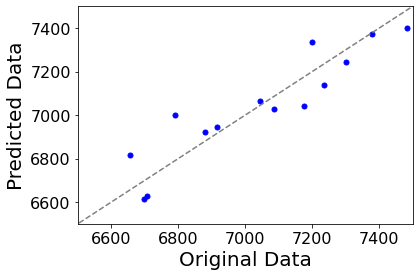

In [15]:
color1 = 'blue'
plt.xlabel('Original Data',fontsize = ft2)
plt.ylabel('Predicted Data',fontsize = ft2)
plt.scatter(df['k'],df['km'],c = color1,marker = 'o',s = 25)
color2 = 'grey'
plt.plot([6000,8000],[6000,8000],c=color2,linestyle='--')
plt.xlim([6500,7500])
plt.ylim([6500,7500])
plt.savefig('finalplot.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

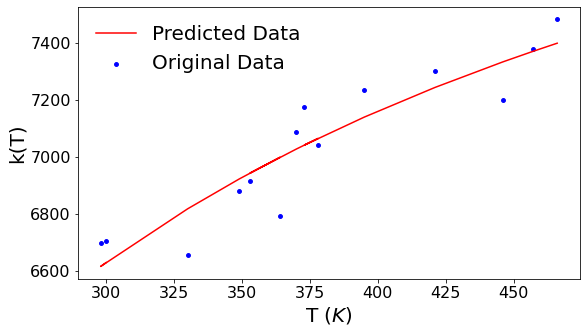

In [16]:
plt.figure(figsize=(9,5))
color1 = 'blue'
plt.xlabel('T ($K$)',fontsize = ft2)
plt.ylabel('k(T)',fontsize = ft2)
plt.scatter(df['T'],df['k'],c = color1,marker = 'o',s = 15,label = 'Original Data')
color2 = 'red'
plt.plot(df['T'],df['km'],c=color2, label = 'Predicted Data')
plt.legend(frameon = False,fontsize = ft2)
plt.savefig('finalplot2.png',format='png',dpi = 600,bbox_inches = 'tight')
plt.show()

# F-teste & Região de Confiança

In [17]:
from scipy import stats   #Pacote de funcoes estatisticas 

$$
S(\theta)  \leq \left[ \frac{p}{n-p} F(\alpha,p,n-p)\right]S(\theta^*) + S(\theta^*)
$$

In [18]:
def RCfun(par):
    global RC
    dftemp = df.copy()
    dftemp['km'] = modelo(par[0],par[1],dftemp['T']) # km = k modelo
    dftemp['error'] = (dftemp['k'] - dftemp['km'])**2
    SSE = dftemp['error'].sum() # residual sum of squares
    RC = RC.append({'A':par[0],'Ea':par[1],'Fobj':SSE}, ignore_index=True)

In [ ]:
fotm = SSE
p = len(x0) # number of parameters
n = N # number of data points
α = 0.95 # alpha, confidence interval
F_fisher = stats.f.ppf(α, p, (n-p))
rhs = p/(n-p)*F_fisher*fotm + fotm # right hand side of the last equation

nn = 100
perc = 0.9
k1 = np.linspace(-res.x[0]*perc+res.x[0],res.x[0]*perc+res.x[0],nn)
k2 = np.linspace(-res.x[1]*perc+res.x[1],res.x[1]*perc+res.x[1],nn)

global RC
RC = pd.DataFrame()
for i in range(nn):
    for j in range(nn):
        RCfun([k1[i],k2[j]])
    print(i)

In [ ]:
nparams = RC.index[-1]+1
for i in range(nparams):
    if RC['Fobj'][i] > rhs:
        RC = RC.drop(i) # deletar essa linha do DataFrame
RC = RC.reset_index(drop=True)

In [ ]:
plt.scatter(RC['A'],RC['Ea'],s = 50, c = 'black',alpha = 0.1)
plt.scatter(res.x[0],res.x[1],s = 15, c = 'red')
plt.xlabel('A')
plt.ylabel("$E_a$")
#plt.xlim([9027,9029])
#plt.ylim([700,800])
plt.show()